# Examen Práctico – Redes Neuronales  
## Implementación de un Perceptrón para Regresión  


En este notebook se desarrolla paso a paso la implementación de un perceptrón simple para un problema de regresión, utilizando el conjunto de datos **California Housing**.

El objetivo es conectar de manera explícita la teoría presentada en el libro (conceptos como vector de características, pesos, sesgo, suma ponderada y
función de pérdida) con una implementación práctica en Python, empleando principalmente **NumPy** y herramientas básicas de **scikit-learn** para la
carga y normalización de los datos.

El notebook funciona como un cuaderno de trabajo experimental, donde se implementan y prueban los distintos componentes del modelo, mientras que las
justificaciones teóricas detalladas se presentan por separado en el documento `respuestas_teoricas.md`.

En esta sección se carga el conjunto de datos California Housing utilizando
`fetch_california_housing` de sklearn. Se extraen las características de entrada
y la variable objetivo, y se imprime una descripción general del dataset para
entender su estructura.

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar el dataset
california = fetch_california_housing()
X = california.data
y = california.target
feature_names = california.feature_names

print('Descripción del dataset:')
print(california.DESCR[:1500])

Descripción del dataset:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. cen

El conjunto de datos se divide en subconjuntos de entrenamiento y prueba.
Posteriormente, las características se normalizan usando `StandardScaler`
para garantizar una escala uniforme, lo cual es importante para el entrenamiento
estable del perceptrón.

In [2]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)


X_train_scaled shape: (16512, 8)


Se inicializan los parámetros del perceptrón: el vector de pesos `w` y el sesgo `b`.
Los pesos se inicializan con valores aleatorios pequeños y el sesgo en cero,
siguiendo las recomendaciones teóricas del modelo del perceptrón.

In [3]:
import numpy as np

def inicializar_parametros(n_caracteristicas):
    '''
    Inicializa los pesos y el sesgo del perceptrón.
    '''
    w = np.random.randn(n_caracteristicas, 1) * 0.01
    b = 0.0
    return w, b


In [4]:
w, b = inicializar_parametros(X_train_scaled.shape[1])
print("Forma de w:", w.shape)
print("Sesgo b:", b)

Forma de w: (8, 1)
Sesgo b: 0.0


### Propagación hacia adelante (suma ponderada)

En esta sección se implementa la propagación hacia adelante del perceptrón.
Siguiendo el Capítulo 2 del material del curso, se calcula la suma ponderada:

\[
z = X \mathbf{w} + b
\]

donde \(X\) es la matriz de características, \(\mathbf{w}\) el vector de pesos y \(b\) el sesgo.
En un problema de regresión, esta salida corresponde directamente a la predicción del modelo.


In [5]:
def propagacion_adelante(X, w, b):
    '''
    Calcula la suma ponderada para todas las observaciones.
    '''
    y_pred = X @ w + b
    return y_pred

In [6]:
# Predicciones iniciales para los primeros 5 ejemplos
y_pred_5 = propagacion_adelante(X_train_scaled[:5], w, b)

print("Predicciones iniciales:")
print(y_pred_5.flatten())

print("\nValores reales:")
print(y_train[:5])

Predicciones iniciales:
[-0.01592538 -0.015808   -0.01190661 -0.01601347  0.00966272]

Valores reales:
[1.03  3.821 1.726 0.934 0.965]


Las predicciones iniciales no son precisas, ya que el modelo aún no ha sido entrenado.
Los pesos se inicializaron con valores aleatorios pequeños, por lo que la salida inicial
del modelo es cercana a cero.

### Función de pérdida: Error Cuadrático Medio (MSE)

En problemas de regresión, la calidad de las predicciones se evalúa mediante una función de pérdida.
En este trabajo se utiliza el **Error Cuadrático Medio (MSE)**, que mide el promedio del cuadrado de las diferencias entre las predicciones del modelo y los valores reales.


In [7]:
def calcular_perdida(y_pred, y_real):
    '''
    Calcula el error cuadrático medio (MSE).

    MSE = (1/m) * sum((y_pred - y_real)^2)
    '''
    m = y_real.shape[0]
    mse = (1 / m) * np.sum((y_pred - y_real) ** 2)
    return mse

In [8]:
# Calcular predicciones iniciales
y_pred_inicial = propagacion_adelante(X_train_scaled, w, b)

# Calcular pérdida inicial
perdida_inicial = calcular_perdida(y_pred_inicial, y_train.reshape(-1, 1))

perdida_inicial

np.float64(5.641954336464958)

## Cálculo de gradientes

En esta sección se implementa el cálculo de los gradientes de la función de pérdida
(MSE) respecto a los pesos \(w\) y al sesgo \(b\), siguiendo las expresiones
derivadas en la Parte III del reporte teórico.

In [9]:
# Propagación hacia adelante
y_pred = propagacion_adelante(X_train_scaled, w, b)

print("Forma de y_pred:", y_pred.shape)

Forma de y_pred: (16512, 1)


In [10]:
def calcular_gradientes(X, y_pred, y_real):
    '''
    Calcula los gradientes de la pérdida respecto a w y b.
    
    Parámetros:
    -----------
    X : numpy array de forma (m, n)
    y_pred : numpy array de forma (m, 1)
    y_real : numpy array de forma (m, 1)
    
    Retorna:
    --------
    dw : numpy array de forma (n, 1) - gradiente respecto a w
    db : float - gradiente respecto a b
    '''
    m = X.shape[0]
    
    # Error de predicción
    error = y_pred - y_real.reshape(-1, 1)
    
    # Gradientes
    dw = (2 / m) * X.T @ error
    db = (2 / m) * np.sum(error)
    
    return dw, db

In [11]:
dw, db = calcular_gradientes(X_train_scaled, y_pred, y_train)

print("Forma de w:", w.shape)
print("Forma de dw:", dw.shape)
print("Gradiente db:", db)

Forma de w: (8, 1)
Forma de dw: (8, 1)
Gradiente db: -4.143893874757754


## Actualización de parámetros

En esta sección se implementa la regla de actualización de los pesos y el sesgo
mediante descenso del gradiente, con el objetivo de reducir la función de pérdida.

In [12]:
def actualizar_parametros(w, b, dw, db, learning_rate):
    '''
    Actualiza los pesos y el sesgo usando gradiente descendente.
    
    w_nuevo = w - learning_rate * dw
    b_nuevo = b - learning_rate * db
    '''
    w = w - learning_rate * dw
    b = b - learning_rate * db
    
    return w, b


### Una iteración del descenso del gradiente

A continuación se ejecuta una iteración completa del algoritmo de aprendizaje:
propagación hacia adelante, cálculo de la pérdida, cálculo de gradientes y
actualización de los parámetros.


In [13]:
# Pérdida antes de la actualización
y_pred = propagacion_adelante(X_train_scaled, w, b)
loss_before = calcular_perdida(y_pred, y_train)

# Cálculo de gradientes
dw, db = calcular_gradientes(X_train_scaled, y_pred, y_train)

# Actualización de parámetros
learning_rate = 0.01
w, b = actualizar_parametros(w, b, dw, db, learning_rate)

# Pérdida después de la actualización
y_pred_new = propagacion_adelante(X_train_scaled, w, b)
loss_after = calcular_perdida(y_pred_new, y_train)

print("Pérdida antes:", loss_before)
print("Pérdida después:", loss_after)

Pérdida antes: 92966.33888957997
Pérdida después: 90161.36578003678


## Entrenamiento completo del perceptrón

En esta sección se implementa el ciclo completo de entrenamiento del perceptrón
utilizando descenso del gradiente, registrando la evolución de la función de pérdida
a lo largo de las épocas.

In [14]:
def entrenar_perceptron(X_train, y_train, learning_rate=0.01, epochs=1000):
    '''
    Entrena un perceptrón para regresión.
    '''
    n_caracteristicas = X_train.shape[1]
    w, b = inicializar_parametros(n_caracteristicas)
    historial_perdida = []

    for epoca in range(epochs):
        # 1. Propagación hacia adelante
        y_pred = propagacion_adelante(X_train, w, b)

        # 2. Calcular pérdida
        perdida = calcular_perdida(y_pred, y_train)
        historial_perdida.append(perdida)

        # 3. Calcular gradientes
        dw, db = calcular_gradientes(X_train, y_pred, y_train)

        # 4. Actualizar parámetros
        w, b = actualizar_parametros(w, b, dw, db, learning_rate)

        if epoca % 100 == 0:
            print(f'Época {epoca}, Pérdida: {perdida:.4f}')

    return w, b, historial_perdida


In [26]:
w_trained, b_trained, historial_trained = entrenar_perceptron(
    X_train_scaled, y_train,
    learning_rate=0.01,
    epochs=1000
)

Época 0, Pérdida: 92964.9089
Época 100, Pérdida: 31792.7906
Época 200, Pérdida: 33000.4947
Época 300, Pérdida: 33504.4109
Época 400, Pérdida: 33747.2133
Época 500, Pérdida: 33944.6241
Época 600, Pérdida: 34127.3091
Época 700, Pérdida: 34297.2753
Época 800, Pérdida: 34453.2670
Época 900, Pérdida: 34594.4994


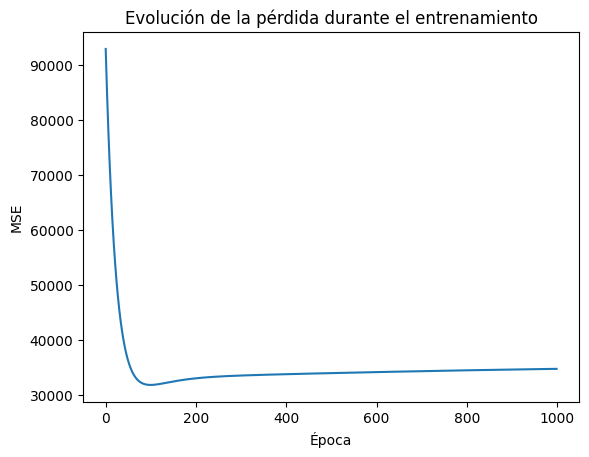

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(historial_trained)
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.show()

## Comparación de tasas de aprendizaje

En esta sección se entrena el perceptrón con distintas tasas de aprendizaje
para analizar su efecto sobre la convergencia del algoritmo de descenso del gradiente.
Se comparan las curvas de pérdida para learning rates: 0.001, 0.01, 0.1 y 1.0.

In [17]:
import matplotlib.pyplot as plt

learning_rates = [0.001, 0.01, 0.1, 1.0]
historiales = {}

for lr in learning_rates:
    print(f"\nEntrenando con learning_rate = {lr}")
    w_lr, b_lr, historial = entrenar_perceptron(
        X_train_scaled,
        y_train,
        learning_rate=lr,
        epochs=1000
    )
    historiales[lr] = historial


Entrenando con learning_rate = 0.001
Época 0, Pérdida: 92964.2280
Época 100, Pérdida: 69992.7956
Época 200, Pérdida: 55245.8951
Época 300, Pérdida: 45862.9616
Época 400, Pérdida: 39969.4986
Época 500, Pérdida: 36336.1928
Época 600, Pérdida: 34157.3534
Época 700, Pérdida: 32905.9747
Época 800, Pérdida: 32238.5015
Época 900, Pérdida: 31932.0790

Entrenando con learning_rate = 0.01
Época 0, Pérdida: 92967.2124
Época 100, Pérdida: 31888.0103
Época 200, Pérdida: 33019.6524
Época 300, Pérdida: 33513.0420
Época 400, Pérdida: 33754.4165
Época 500, Pérdida: 33951.2758
Época 600, Pérdida: 34133.3476
Época 700, Pérdida: 34302.6120
Época 800, Pérdida: 34457.8735
Época 900, Pérdida: 34598.3951

Entrenando con learning_rate = 0.1
Época 0, Pérdida: 92968.8783
Época 100, Pérdida: 34723.1094
Época 200, Pérdida: 35384.1386
Época 300, Pérdida: 35541.0811
Época 400, Pérdida: 35578.8783
Época 500, Pérdida: 35588.9982
Época 600, Pérdida: 35592.0532
Época 700, Pérdida: 35593.0717
Época 800, Pérdida: 35593.4

c:\Users\Henry Cifuente\Desktop\california-housing-perceptron\venv\Lib\site-packages\numpy\_core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Henry Cifuente\AppData\Local\Temp\ipykernel_20496\4186274290.py:8: RuntimeWarning: overflow encountered in square
  mse = (1 / m) * np.sum((y_pred - y_real) ** 2)


Época 400, Pérdida: inf
Época 500, Pérdida: inf
Época 600, Pérdida: inf


C:\Users\Henry Cifuente\AppData\Local\Temp\ipykernel_20496\3520384759.py:22: RuntimeWarning: invalid value encountered in matmul
  dw = (2 / m) * X.T @ error
C:\Users\Henry Cifuente\AppData\Local\Temp\ipykernel_20496\469520138.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  b = b - learning_rate * db


Época 700, Pérdida: nan
Época 800, Pérdida: nan
Época 900, Pérdida: nan


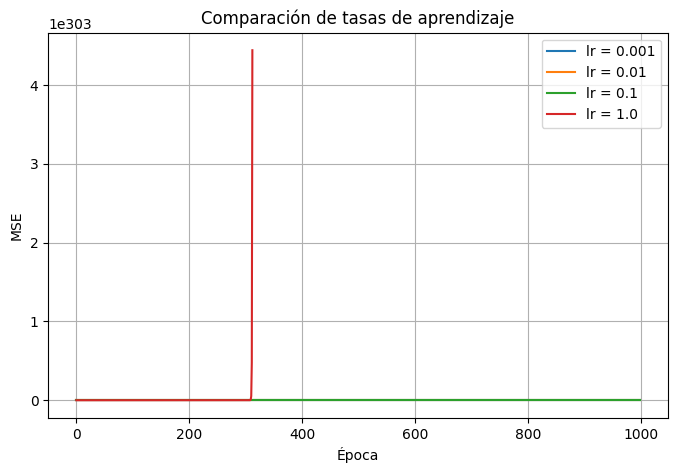

In [18]:
plt.figure(figsize=(8, 5))

for lr, historial in historiales.items():
    plt.plot(historial, label=f"lr = {lr}")

plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Comparación de tasas de aprendizaje")
plt.legend()
plt.grid(True)
plt.show()

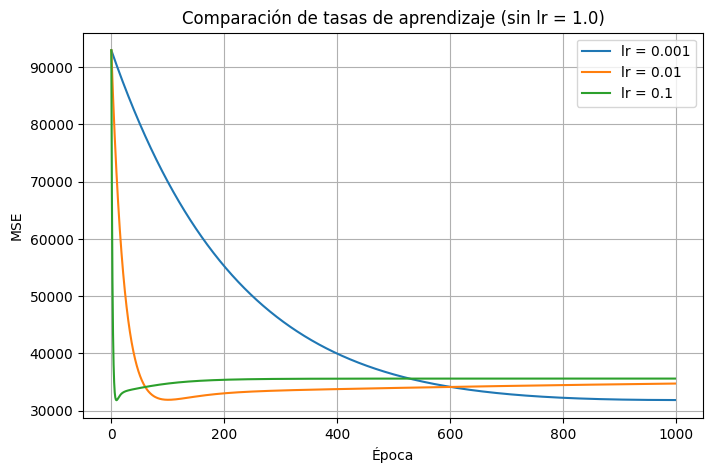

In [19]:
plt.figure(figsize=(8, 5))

for lr in [0.001, 0.01, 0.1]:
    plt.plot(historiales[lr], label=f"lr = {lr}")

plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Comparación de tasas de aprendizaje (sin lr = 1.0)")
plt.legend()
plt.grid(True)
plt.show()

## Evaluación en el conjunto de prueba
En esta sección se evalúa el desempeño del perceptrón entrenado sobre el conjunto de prueba.
Se calculan las predicciones, el error cuadrático medio (MSE), una gráfica de dispersión
entre valores reales y predichos, y el coeficiente de determinación R² para analizar la
capacidad de generalización del modelo.


In [29]:
# Predicciones sobre el conjunto de prueba
y_test_pred = propagacion_adelante(X_test_scaled, w_trained, b_trained)

print("Forma de y_test_pred:", y_test_pred.shape)

Forma de y_test_pred: (4128, 1)


In [30]:
# Cálculo del MSE en test
mse_test = calcular_perdida(y_test_pred, y_test)

print("MSE en entrenamiento (final):", historial_trained[-1])
print("MSE en conjunto de prueba:", mse_test)

MSE en entrenamiento (final): 34719.77703911322
MSE en conjunto de prueba: 8617.349191391135


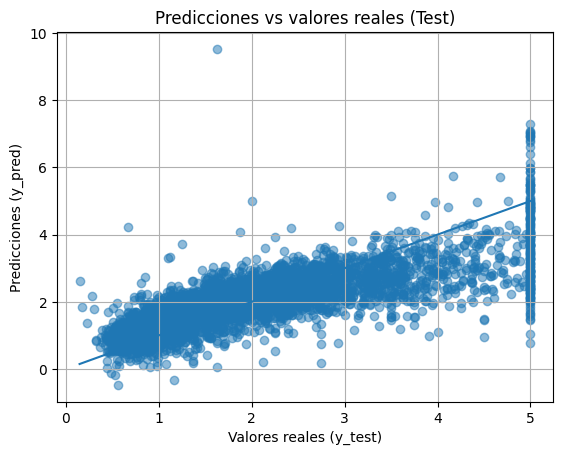

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Predicciones vs valores reales (Test)")
plt.grid(True)
plt.show()

In [32]:
# Cálculo del coeficiente R²
SS_res = np.sum((y_test - y_test_pred.flatten())**2)
SS_tot = np.sum((y_test - np.mean(y_test))**2)
R2 = 1 - (SS_res / SS_tot)

print("Coeficiente de determinación R²:", R2)

Coeficiente de determinación R²: 0.576922558230277
